<img src="icon.png" width="50"/> ![Badge](https://img.shields.io/badge/Workshop%20SMLMS%202025-FF1010?style=for-the-badge)
## Single Molecule Tracking and Diffusion

 *[Daniel Sage](mailto:daniel.sage@epfl.ch?subject=Single%20Molecule%20Tracking%20and%20Diffusion), Ecole Polytechnique Fédérale de Lausanne, Switerzland*


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Simulation Isotropic, Anisotropic, and Non-Homogeneous Brownian Motion

In [42]:
# Common Parameters
N_PARTICLES = 25
N_PLOT = 10
STEPS = 25
DT = 0.1
FOV = 20

### Common functions

In [43]:
# --- Helpers ----
def compute_msd(traj):
    msd = []
    disp = traj - traj[0]
    msd = np.sum(disp**2, axis=1)
    return msd

def msd_model(t, A):
    return A * t  # A = 4D for 2D Brownian motion

def fit_D(msd):
    time = np.arange(STEPS) * DT
    popt, _ = curve_fit(msd_model, time[1:], msd[1:], p0=(1.0,), maxfev=10000) 
    return popt[0] / 4

def plot_traj_msd(trajectories, msds, fitted, prefix=''):

    mean_D = np.mean(fitted)
    std_D = np.std(fitted)
    colors = np.random.rand(N_PLOT, 3)
    fig, (ax_traj, ax_msd, ax_disp) = plt.subplots(1, 3, figsize=(15, 5))

    # Left: trajectories
    for i in range(N_PLOT):
        ax_traj.plot(trajectories[i][:, 0], trajectories[i][:, 1], color=colors[i], label=f"P{i}")
    ax_traj.set_title(f"{prefix} Brownian Motion Trajectories (first {N_PLOT})")
    ax_traj.axis("equal")
    time = np.arange(STEPS) * DT
    
    # Center: MSD curves and fits
    for i in range(N_PLOT):
        msd = msds[i]
        ax_msd.plot(time, msd, color=colors[i], label=f"P{i}")
        if not np.isnan(fitted[i]):
            D = fitted[i]
            ax_msd.plot(time, 4 * D * time, '--', color=colors[i], label=f"P{i} fit (D ≈ {D:.2f})")

    ax_msd.set_title(f"{prefix} - MSD with Fitted D (first {N_PLOT})")
    ax_msd.grid(True)
    ax_msd.text(0.45, 0.90, f"Mean D  ≈ {mean_D:.4f}\nStdev ≈ {std_D:.4f}", transform=ax_msd.transAxes, fontsize=12)

    # Right: Displacement Vectors
    for i in range(N_PLOT):
        traj = trajectories[i]
        dx = np.diff(traj[:,0])
        dy = np.diff(traj[:,1])
        for k in range(dx.shape[0]):
            ax_disp.arrow(0, 0, dx[k], dy[k], head_width=0.01, alpha=0.5, color=colors[i])
    ax_disp.set_title('Displacement Vectors')
    ax_disp.grid(True)
    ax_disp.axis('equal')

    plt.tight_layout()
    plt.show()

### Isotropic Brownian Motion

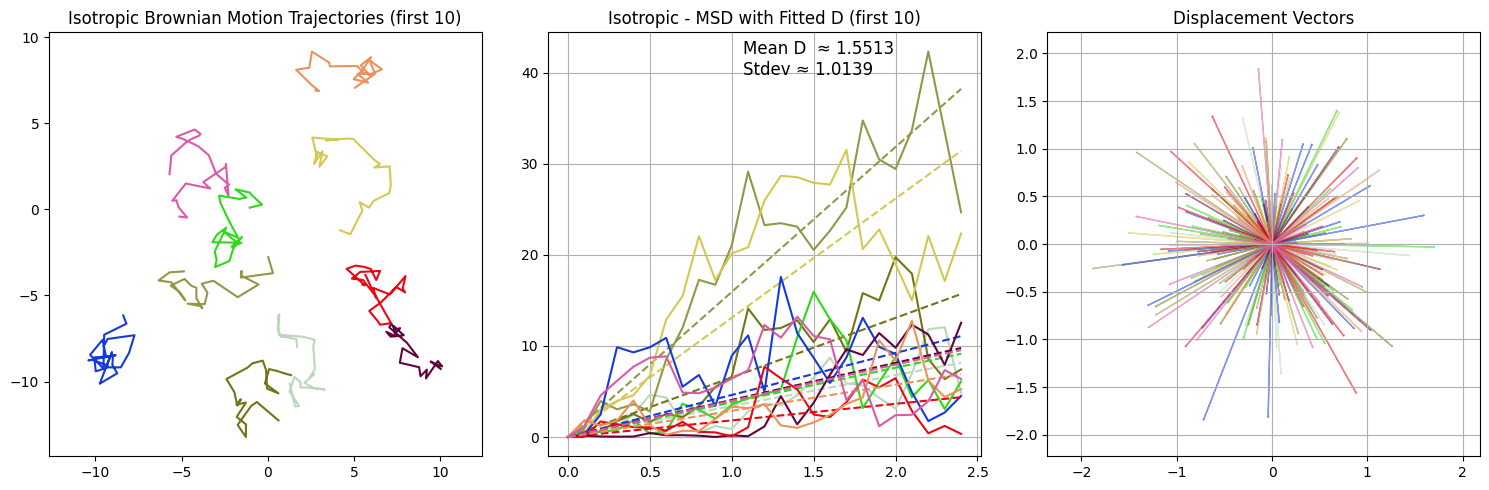

In [44]:
# --- Parameters ---
D_TRUE = 2.0  # True diffusion coefficient

# --- Brownian trajectory generator ---
def generate_isotropic_brownian_trajectory(steps, dt, D):
    start = np.random.uniform(-FOV/2, FOV/2, size=2)
    traj = np.zeros((steps, 2))
    traj[0] = start
    for t in range(1, steps):
        step = np.random.randn(2) * np.sqrt(2 * D * dt)
        traj[t] = traj[t - 1] + step
        
    return traj

trajectories = []
msds = []
fitted_D = []

for i in range(N_PARTICLES):
    traj = generate_isotropic_brownian_trajectory(STEPS, DT, D_TRUE)
    trajectories.append(traj)
    msd = compute_msd(traj)
    msds.append(msd)
    D = fit_D(msd)
    fitted_D.append(D)

plot_traj_msd(trajectories, msds, fitted_D, 'Isotropic')

### Anisotropic Brownian Motion

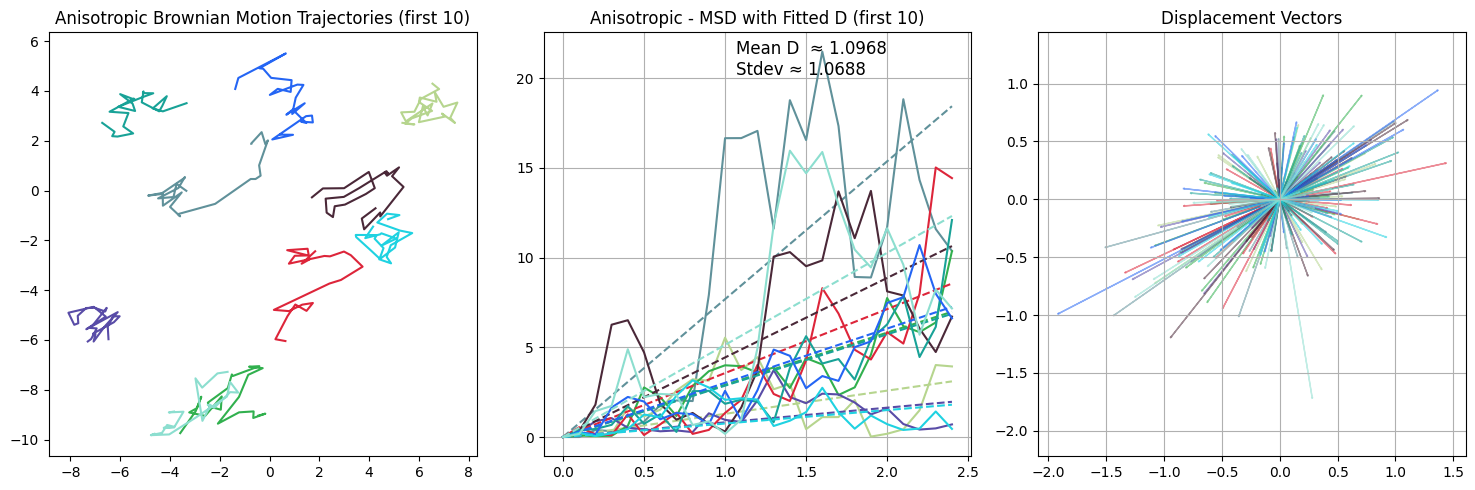

In [46]:
# --- Parameters ---
D1 = 2        # diffusion along principal axis 1
D2 = 0.5      # diffusion along principal axis 2
THETA = np.pi/6  # orientation angle (radians)

# --- Build 2D diffusion tensor ---
def build_diffusion_tensor(D1, D2, theta):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    Lambda = np.diag([D1, D2])
    return R @ Lambda @ R.T  # Rotate the diagonal diffusion matrix

D_tensor = build_diffusion_tensor(D1, D2, THETA)
cov_matrix = 2 * D_tensor * DT

# --- Generate trajectory from multivariate Gaussian ---
def generate_anisotropic_trajectory(steps, cov):
    start = np.random.uniform(-FOV/2, FOV/2, size=2)
    traj = np.zeros((steps, 2))
    traj[0] = start
    for t in range(1, steps):
        step = np.random.multivariate_normal(mean=[0, 0], cov=cov)
        traj[t] = traj[t-1] + step
    return traj

# --- Simulate ---
trajectories = []
fitted_D = []
msds = []

for _ in range(N_PARTICLES):
    traj = generate_anisotropic_trajectory(STEPS, cov_matrix)
    trajectories.append(traj)
    msd = compute_msd(traj)
    msds.append(msd)
    D = fit_D(msd)
    fitted_D.append(D)

plot_traj_msd(trajectories, msds, fitted_D, 'Anisotropic')

### Non-homogeneous Brownian Motion

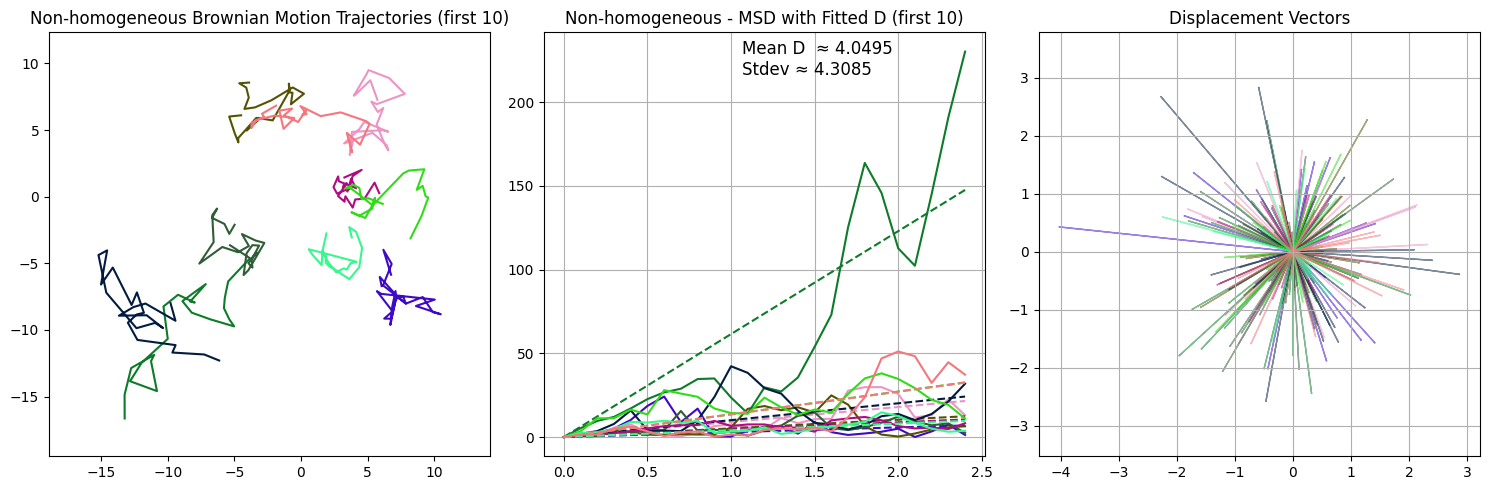

In [47]:
# --- Brownian Motion with Spatially Varying D(x, y) ---
def generate_spatially_nonhomogeneous_brownian_trajectory(steps, dt, D_func):
    start = np.random.uniform(-FOV/2, FOV/2, size=2)
    traj = np.zeros((steps, 2))
    traj[0] = start
    for t in range(1, steps):
        x, y = traj[t - 1]
        D_xy = D_func(x, y)  # <-- D depends on current position
        step = np.random.randn(2) * np.sqrt(2 * D_xy * dt)
        traj[t] = traj[t - 1] + step
    return traj

# --- Example spatial profile for D(x, y) ---
def D_space(x, y):
    # Diffusion increases with distance from the origin
    r = np.sqrt(x**2 + y**2)
    return 0.25 + 0.5 * r

# --- Simulate ---
trajectories = []
msds = []
fitted_D = []

for i in range(N_PARTICLES):
    traj = generate_spatially_nonhomogeneous_brownian_trajectory(STEPS, DT, D_space)
    trajectories.append(traj)
    msd = compute_msd(traj)
    msds.append(msd)
    D = fit_D(msd)
    fitted_D.append(D)

plot_traj_msd(trajectories, msds, fitted_D, 'Non-homogeneous')
